# Model 000 basic coupled steady state solution

This notebook is for the EMS paper. It will have a model000 landscape at steady state. There will be two outputs from this notebook: 1) a NetCDF file of the topography, which we will use to make an oblique Paraview image of the landscape, and 2) a slope-area plot at steady state.

Importantly, this will be one of the "user-friendly" notebooks that get submitted along with the EMS paper.

#### Charlie working on

In [1]:
from erosion_model import Basic
import numpy as np
import matplotlib.pyplot as plt
from landlab import imshow_grid

//anaconda/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
#parameter dictionary
params = { 'number_of_node_rows' : 100,
          'number_of_node_columns' : 160,
          'node_spacing' : 10.0,
          'east_boundary_closed' : False,
          'north_boundary_closed' : False,
          'west_boundary_closed' : False,
          'south_boundary_closed' : False,
          'dt' : 10.0,
          'K_sp' : 0.001,
          'm_sp' : 0.5,
          'n_sp' : 1.0,
          'linear_diffusivity' : 0.2,
          'outlet_lowering_rate' : 0.0005,
          'output_filename': 'model_000_output'
}

In [3]:
basic = Basic(params=params)
tolerance = 0.0001 #for determining steady state

In [4]:
dt = 10
elapsed_time = 0 #years
keep_running = True
while keep_running == True:
    pre_topo = basic.grid.at_node['topographic__elevation'][basic.grid.core_nodes]
    basic.run_one_step(dt)
    post_topo = basic.grid.at_node['topographic__elevation'][basic.grid.core_nodes]
    if elapsed_time % 1000 == 0:
        print elapsed_time
        print 'MAX: ', max(abs(pre_topo - post_topo))
        print 'MEAN: ', np.average(abs(pre_topo - post_topo))
    elapsed_time += dt
    if max(abs(pre_topo - post_topo)) <= tolerance: #1mm
        keep_running = False

0
MAX:  0.0929166901073
MEAN:  0.01788189295
1000
MAX:  0.0101406168967
MEAN:  0.00388190994212
2000
MAX:  0.0128536593277
MEAN:  0.00337834504617
3000
MAX:  0.00505263647596
MEAN:  0.00285332185999
4000
MAX:  0.00501321798916
MEAN:  0.00236104302176
5000
MAX:  0.0140242122403
MEAN:  0.00193392124212
6000
MAX:  0.00556927937155
MEAN:  0.00153444175685
7000
MAX:  0.0146149488387
MEAN:  0.00122015028292
8000
MAX:  0.0091732565674
MEAN:  0.000992724279146
9000
MAX:  0.00606728724395
MEAN:  0.000792383226402
10000
MAX:  0.00439420438719
MEAN:  0.00061534477013
11000
MAX:  0.00787503766842
MEAN:  0.000500461317986
12000
MAX:  0.00498203584192
MEAN:  0.00041567788068
13000
MAX:  0.00580403033245
MEAN:  0.000362919675144
14000
MAX:  0.00443209099887
MEAN:  0.000323205988863
15000
MAX:  0.00327054048717
MEAN:  0.000308436283806
16000
MAX:  0.00308218496143
MEAN:  0.000292372866
17000
MAX:  0.00379809293733
MEAN:  0.000268010040135
18000
MAX:  0.00408698078854
MEAN:  0.000252304454578
19000
MAX

In [5]:
###MAKE SLOPE-AREA PLOT

import matplotlib

#assign area_array and slope_array
area_array = basic.grid.at_node['drainage_area'][(basic.grid.node_x > 10)&(basic.grid.node_x < 1580)&(basic.grid.node_y >10)&(basic.grid.node_y<980)]
slope_array = basic.grid.at_node['topographic__steepest_slope'][(basic.grid.node_x > 10)&(basic.grid.node_x < 1580)&(basic.grid.node_y >10)&(basic.grid.node_y<980)]

#plotting param
matplotlib.rcParams.update({'font.size': 20})

##instantiate figure and plot
fig = plt.figure(figsize=(6, 3.75))
slope_area = plt.subplot()

#create an array for the detachment-limited analytical solution
u = 0.0005 #m/yr, uplift or baselevel lowering rate
k = 0.001 #fluvial erodibility
m = 0.5 #discharge exponent
n = 1.0 #slope exponent

#calculate analytical slope from area field
analytical_slope_array = np.power((u / k), 1 / n) * np.power(area_array, -m/n)

#plot the analytical solution
#slope_area.plot(area_array, analytical_slope_array, linestyle='-',
#                color='grey', linewidth = 1, label = 'Analytical solution')

#plot the data
slope_area.scatter(area_array, slope_array, marker='o', c='k', 
                   label = 'Numerical solution') #plot HA data
                   
#make axes log and set limits
slope_area.set_xscale('log')
slope_area.set_yscale('log')

slope_area.set_xlim(9*10**1, 3*10**5)
slope_area.set_ylim(1e-3, 1e-1)

#set x and y labels
slope_area.set_xlabel(r'Drainage area [m$^2$]')
slope_area.set_ylabel('Channel slope [-]')
#slope_area.legend(scatterpoints=1,prop={'size':12})
slope_area.tick_params(axis='x', which='major', pad=7)

fig.savefig('maintext_basic_streampower_slope_area_rev1.eps',bbox_inches='tight', dpi=1000) #save figure

In [6]:
#export NetCDF for Paraview image of topography
from landlab.io.netcdf import write_netcdf
write_netcdf('maintext_basic_stream_power_rev1.nc', basic.grid, format='NETCDF3_64BIT', names='topographic__elevation')

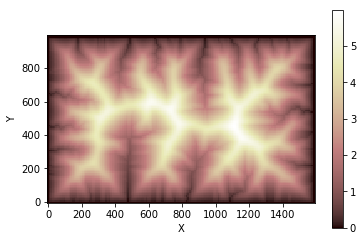

In [7]:
%matplotlib inline
imshow_grid(basic.grid, 'topographic__elevation')